In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from numpy import linspace, loadtxt, ones, convolve

import numpy as np
import pandas as pd


from matplotlib import style
import seaborn as sns
# style.use('fivethirtyeight')
%matplotlib inline

import wrangle as w

In [2]:
df = w.prep_logs()

In [3]:
df.shape

(847330, 10)

In [4]:
df.head(2)

,path,user_id,cohort_id,ip,name,start_date,end_date,program_id,weekday,month
datetime,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,FS_PHP,Friday,1
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,FS_PHP,Friday,1


In [5]:
pages = df['path'].resample('d').count()
pages.head(2)

datetime
2018-01-26    533
2018-01-27    230
Freq: D, Name: path, dtype: int64

In [27]:
type(pages)

pandas.core.series.Series

<AxesSubplot:xlabel='datetime'>

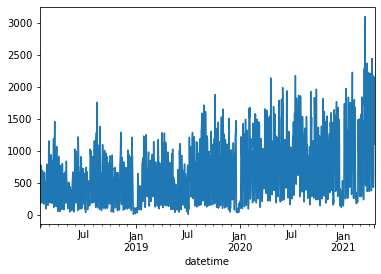

In [6]:
pages.plot()

In [7]:
end_train = '2020-06-30'
start_test = '2020-07-01'

train = pages[:end_train]
test = pages[start_test:]

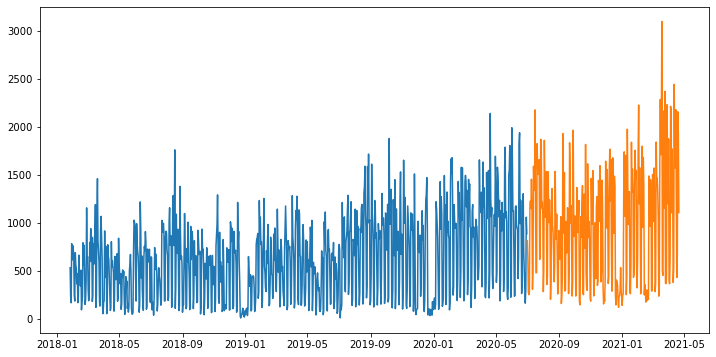

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(train)
plt.plot(test)
plt.show()

In [9]:
pages.isnull().sum()

0

In [10]:
# 7 day EMA
ema_short = train.ewm(span=7).mean()
ema_short.head()

datetime
2018-01-26    533.000000
2018-01-27    359.857143
2018-01-28    276.891892
2018-01-29    461.982857
2018-01-30    511.811780
Freq: D, Name: path, dtype: float64

In [11]:
# 14 days EMA
ema_mid = train.ewm(span=14).mean()
ema_mid.head()

datetime
2018-01-26    533.000000
2018-01-27    370.678571
2018-01-28    293.254669
2018-01-29    443.081581
2018-01-30    487.673935
Freq: D, Name: path, dtype: float64

In [12]:
# 30 days EMA
ema_long = train.ewm(span=30).mean()
ema_long.head()

datetime
2018-01-26    533.000000
2018-01-27    376.450000
2018-01-28    302.284709
2018-01-29    434.739290
2018-01-30    475.525441
Freq: D, Name: path, dtype: float64

In [13]:
# 90 days EMA
ema_longer = train.ewm(span=90).mean()
ema_longer.head()

datetime
2018-01-26    533.000000
2018-01-27    379.816667
2018-01-28    307.636352
2018-01-29    430.467642
2018-01-30    468.823433
Freq: D, Name: path, dtype: float64

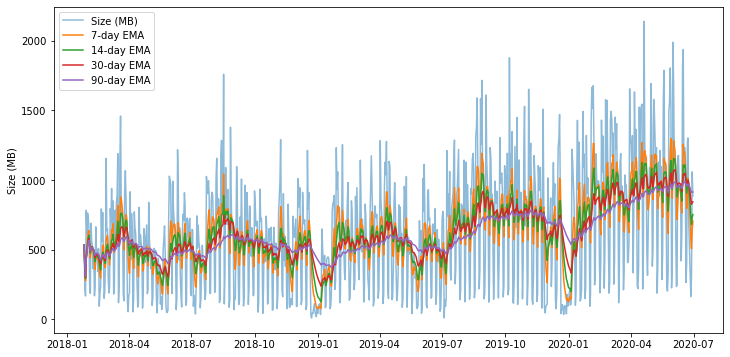

In [14]:

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(train.index, train, label='Size (MB)', alpha=.5)

ax.plot(train.index, ema_short, label = '7-day EMA')
ax.plot(train.index, ema_mid, label = '14-day EMA')
ax.plot(train.index, ema_long, label = '30-day EMA')
ax.plot(train.index, ema_longer, label = '90-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

plt.show()

In [15]:
# set the window span
span = 30

# compute midband
midband = train.ewm(span=span).mean()

midband.head(2)

datetime
2018-01-26    533.00
2018-01-27    376.45
Freq: D, Name: path, dtype: float64

In [16]:
# compute exponential stdev
stdev = train.ewm(span=span).std()

stdev.head(2)

datetime
2018-01-26           NaN
2018-01-27    214.253355
Freq: D, Name: path, dtype: float64

In [18]:
# compute upper and lower bands
ub = midband + stdev*2
lb = midband - stdev*2

# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)

bb.head(3)

,path,path
datetime,,
2018-01-26,NaN,NaN
2018-01-27,804.956709,-52.056709
2018-01-28,687.762221,-83.192803


In [20]:
train = pd.concat([train, midband, bb], axis=1)
train.columns = ['size_gb', 'midband', 'ub', 'lb']

In [21]:
train.head(2)

,size_gb,midband,ub,lb
datetime,,,,
2018-01-26,533,533.00,NaN,NaN
2018-01-27,230,376.45,804.956709,-52.056709


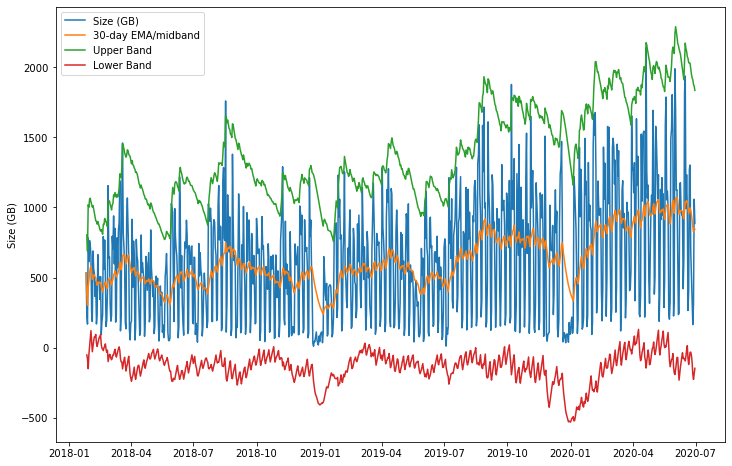

In [22]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(train.index, train.size_gb, label='Size (GB)')

ax.plot(train.index, train.midband, label = '30-day EMA/midband')
ax.plot(train.index, train.ub, label = 'Upper Band')
ax.plot(train.index, train.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Size (GB)')

plt.show()

In [23]:
# get the last measure of gb
last_measure = train.iloc[-1].size_gb


# get the lower band value on the last date
last_lb = train.iloc[-1].lb

# get the upper band value on the last date
last_ub = train.iloc[-1].ub

# compute %b
last_pct_b = (last_measure - last_lb)/(last_ub - last_lb)

print('%b for last datapoint: ', round(last_pct_b, 2))

%b for last datapoint:  0.52


In [24]:
#compute for ea pt in time

train['pct_b'] = (train['size_gb'] - train['lb'])/(train['ub'] - train['lb'])

train.head()

,size_gb,midband,ub,lb,pct_b
datetime,,,,,
2018-01-26,533,533.000000,NaN,NaN,NaN
2018-01-27,230,376.450000,804.956709,-52.056709,0.329116
2018-01-28,168,302.284709,687.762221,-83.192803,0.325820
2018-01-29,783,434.739290,1019.718202,-150.239623,0.797669
2018-01-30,614,475.525441,1001.085795,-50.034912,0.631740


In [25]:

train[train['pct_b']>1]

,size_gb,midband,ub,lb,pct_b
datetime,,,,,
2018-02-27,1156,475.918187,1051.308691,-99.472317,1.090974
2018-03-20,1460,649.891473,1451.666606,-151.883660,1.005197
2018-05-30,1028,375.089886,971.090171,-220.910400,1.047743
2018-07-23,1026,426.685621,997.344326,-143.973083,1.025108
2018-08-17,1760,748.528472,1654.637043,-157.580099,1.058140
2018-11-08,1291,559.032878,1248.528536,-130.462781,1.030799
2019-01-28,1232,446.166837,1165.703309,-273.369635,1.046069
2019-07-08,1212,451.405230,1163.336355,-260.525895,1.034177
2019-10-07,1878,795.149179,1784.161043,-193.862685,1.047441


In [ ]:
# DID NOT USE `ACQUIRE` & `PREP` FUNCTIONS, USED MY OWN FROM `WRANGLE.PY`
def acquire(file_name, column_names):
    """
    `acquire` takes in:
    - file_name: a csv file and reads in
        -separates at whitespace
        -addresses that there is no header
    - column_names: list ['col1', 'col2', ...] of names to rename columns
    - only pulls in certain columns listed in `usecols`
    returns df
    """
    
    return pd.read_csv(file_name, sep="\s", header=None, names=column_names, usecols=[0, 2, 3, 4, 5])

def prep(df, user):
    """
    `prep` takes in 
    - df: created from `acquire`
    - user: user_id that will be filtered on the df
    -converts df.date to datetime type
    -sets df.date to index
    -creates Series `pages` that is the count of daily logs to df.endpoint
    returns pages series
    """
    
    df = df[df.user_id == user]
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    pages = df['endpoint'].resample('d').count()
    return pages

def compute_pct_b(pages, span, weight, user):
    """
    `compute_pct_b` takes in 
    - pages: series created in `prep` that shows daily log counts.
    - span: the number of time periods
    - weight: number being multiplied by the standard deviation
    - user: the numerical user_id assigned to each user that logs on
    creates:
    - my_df: df consisting of `pages` df, with columns appended:
        -midband: exponential weighted moving.average
        -upperband: ewm.mean() + argument specific weighted standard dev
        -lowerband: ewm.mean() - argument specific weighted standard dev
        -pct_b: Percent Bollinger Bandwidth
            - >1: upper bound outlier (above upper band)
            - <1: lower bound outlier (below lower band)
            - == 0.5:lies on the midband
    returns my_df
    """
    
    midband = pages.ewm(span=span).mean()
    stdev = pages.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    bb = pd.concat([ub, lb], axis=1)
    my_df = pd.concat([pages, midband, bb], axis=1)
    my_df.columns = ['pages', 'midband', 'ub', 'lb']
    my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

def plt_bands(my_df, user):
    """
    plt_bands takes in:
    - my_df: df created in compute_pct_b
    - user: the numerical user_id assigned to each user that logs on
    given the specific argument `user` plots:
    - Number of times the user logged on over time
    - Midband, upperband, lowerband for that user over time
    - Labels each line in legend and y-axis
    returns plot
    """
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()
    
def find_anomalies(df, user, span, weight):
    """
    find_anomalies takes in:
    - df: a given df
    - user: the numerical user_id assigned to each user that logs on
    - span: the number of time periods
    - weight: number being multiplied by the standard deviation
    returns a df of `my_df` outliers, where pct_b is above upper band
    """
    
    #creates Series `pages` that is the count of daily logs to df.endpoint
    pages = prep(df, user)
    
    #df consisting of `pages` df, with bollinger bands columns appended
    my_df = compute_pct_b(pages, span, weight, user)
    # plt_bands(my_df, user)
    return my_df[my_df.pct_b>1]